# Challenge Credit Risk

**Packages**

In [123]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#from datetime import date, datetime

In [48]:
#plt.rcParams['figure.figsize'] = [8,5]
#plt.rcParams['font.size'] =14
#plt.rcParams['font.weight']= 'bold'
#plt.style.use('seaborn-whitegrid')

## Business Undestanding

### Questions to answer 

- Pick the best clients you will give a loan to, based on the model you created. It
could be as complex as you decide (even as simpler as knock out rules), as long as
the metrics support it
- Propose an amount to be lended to those clients and a term in which the loan will
need to be paid back.
- Finally choose an anual interest rate the lended amount must have in order to be
profitable.

## Data Understanding

Read datasets

In [3]:
from pathlib import Path
root_dir = Path().resolve()

In [4]:
data_users = pd.read_csv('data/users.csv')
data_credit_reports = pd.read_csv('data/credit_reports.csv', parse_dates=['account_opening_date', 'account_closing_date'])

### Solving the date's format
The dataset `data_credit_reports` has '0000-00-00' values in the column `worst_delinquency_date`, probably due to an error in the date's conversion during the data preparation.

In [5]:
data_credit_reports['worst_delinquency_date'].loc[data_credit_reports['worst_delinquency_date'].str.match('.*\/.*\/.*') == False]

16       0000-00-00
22       0000-00-00
23       0000-00-00
354      0000-00-00
355      0000-00-00
            ...    
15642    0000-00-00
15884    0000-00-00
15885    0000-00-00
15898    0000-00-00
15899    0000-00-00
Name: worst_delinquency_date, Length: 428, dtype: object

In [6]:
data_credit_reports['worst_delinquency_date'].replace({"0000-00-00": np.NaN}, inplace=True)
data_credit_reports['worst_delinquency_date'] = pd.to_datetime(data_credit_reports['worst_delinquency_date'], 
                                                              format='%m/%d/%y')

### Exploring user's Income and outcome 

In [7]:
data_users.head(10)

,id,monthly_income,monthly_outcome,class
0,0,255359,151439,1
1,1,8940,789,0
2,2,11436,3316,0
3,3,17143,47547,1
4,4,26990,15585,1
5,5,166,5240,0
6,6,111662,108374,1
7,7,6271,44469,1
8,8,31695,3021,0
9,9,2401260,6496313,0


In [127]:
data_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   id               1000 non-null   int64
 1   monthly_income   1000 non-null   int64
 2   monthly_outcome  1000 non-null   int64
 3   class            1000 non-null   int64
dtypes: int64(4)
memory usage: 31.4 KB


#### Distribution of user's Income and outcome 

In [126]:
"""
# Set up the matplotlib figure
sns.set_palette("tab10")
fig, axes = plt.subplots(1, 2, figsize=(12, 7), sharex=True)
fig.suptitle("Monthly Income and outcome for each user's class")

#plt.figure(figsize=(8, 6))
sns.boxplot(x='class', y='monthly_income', data=data_users, showfliers=True, ax=axes[0])
#plt.show()

#plt.figure(figsize=(8, 6))
sns.boxplot(x='class', y='monthly_outcome', data=data_users, showfliers=True, ax=axes[1])
#plt.show()

axes1, axes2 = axes.ravel()
axes1.set_ylim(0, 0.5e6) 
axes2.set_ylim(0, 0.5e6) 

#plt.setp(axes, yticks=[])
plt.tight_layout()
"""

'\n# Set up the matplotlib figure\nsns.set_palette("tab10")\nfig, axes = plt.subplots(1, 2, figsize=(12, 7), sharex=True)\nfig.suptitle("Monthly Income and outcome for each user\'s class")\n\n#plt.figure(figsize=(8, 6))\nsns.boxplot(x=\'class\', y=\'monthly_income\', data=data_users, showfliers=True, ax=axes[0])\n#plt.show()\n\n#plt.figure(figsize=(8, 6))\nsns.boxplot(x=\'class\', y=\'monthly_outcome\', data=data_users, showfliers=True, ax=axes[1])\n#plt.show()\n\naxes1, axes2 = axes.ravel()\naxes1.set_ylim(0, 0.5e6) \naxes2.set_ylim(0, 0.5e6) \n\n#plt.setp(axes, yticks=[])\nplt.tight_layout()\n'

In [177]:
data_users.describe()

,id,monthly_income,monthly_outcome,class
count,1000.000000,1.000000e+03,1.000000e+03,1000.000000
mean,499.500000,1.216138e+05,1.249657e+05,0.535000
std,288.819436,4.709416e+05,5.796281e+05,0.499023
min,0.000000,1.000000e+00,1.000000e+00,0.000000
25%,249.750000,2.691250e+03,3.397750e+03,0.000000
50%,499.500000,1.253350e+04,1.424250e+04,1.000000
75%,749.250000,5.868600e+04,5.722850e+04,1.000000
max,999.000000,9.344842e+06,9.749651e+06,1.000000


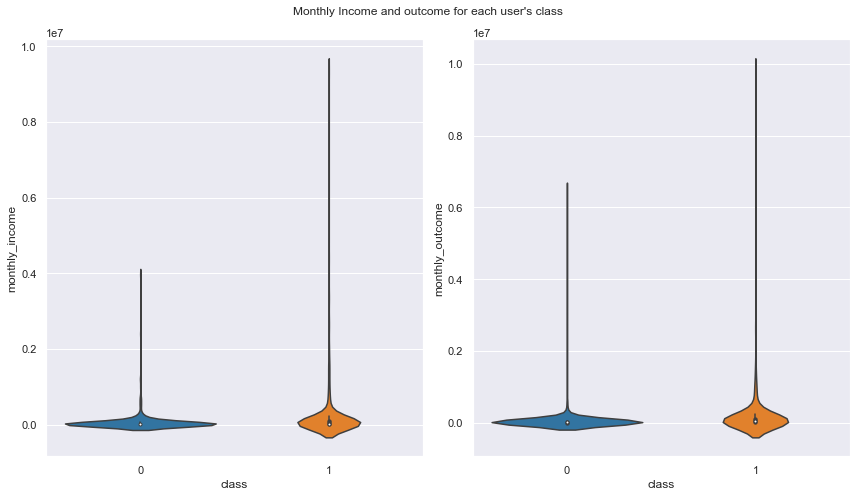

In [124]:
# Set up the matplotlib figure
sns.set_palette("tab10")
fig, axes = plt.subplots(1, 2, figsize=(12, 7), sharex=True)
fig.suptitle("Monthly Income and outcome for each user's class")

#plt.figure(figsize=(8, 6))
sns.violinplot(x='class', y='monthly_income', data=data_users, showfliers=True, ax=axes[0])
#plt.show()

#plt.figure(figsize=(8, 6))
sns.violinplot(x='class', y='monthly_outcome', data=data_users, showfliers=True, ax=axes[1])
#plt.show()

#axes1, axes2 = axes.ravel()
#axes1.set_ylim(0, 0.5e6) 
#axes2.set_ylim(0, 0.5e6) 

#plt.setp(axes, yticks=[])
plt.tight_layout()

Los valores se encuentran sesgados hacia valores mas altos

#### Amount of each class

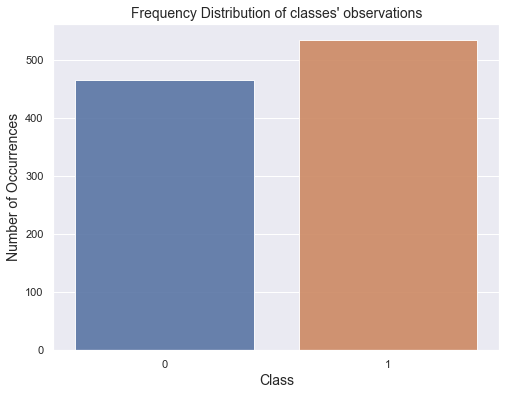

In [160]:
plt.figure(figsize=(8, 6))
class_count = pd.DataFrame(data_users['class'].value_counts())
#sns.set(style="darkgrid")
sns.barplot(x=class_count.index, y=class_count['class'],  data=class_count, alpha=0.9)
plt.title("Frequency Distribution of classes' observations", fontsize=14)
plt.ylabel('Number of Occurrences', fontsize=14)
plt.xlabel('Class', fontsize=14)
plt.show()

La cantidad de observaciones en cada clase se encuentran balanceadas. No existen una considerable diferencia entre ambos

### Exploring user's credit reports

In [173]:
data_credit_reports.head(10)

,user_id,institution,account_type,credit_type,total_credit_payments,payment_frequency,amount_to_pay_next_payment,account_opening_date,account_closing_date,maximum_credit_amount,current_balance,credit_limit,past_due_balance,number_of_payments_due,worst_delinquency,worst_delinquency_date,worst_delinquency_past_due_balance
0,0,MERCANCIA PARA HOGAR Y OFICINA,Pagos Fijos,Línea de Crédito,78.0,Semanal,0.0,2014-11-10,2015-12-05,9826.0,0.0,0.0,0.0,0.0,0.0,NaT,0.0
1,0,MERCANCIA PARA HOGAR Y OFICINA,Pagos Fijos,Préstamo Personal,80.0,Semanal,0.0,2015-12-05,2016-10-14,16000.0,0.0,0.0,0.0,3.0,1.0,2016-05-28,200.0
2,0,MERCANCIA PARA HOGAR Y OFICINA,Pagos Fijos,Línea de Crédito,102.0,Semanal,100.0,2016-09-02,NaT,10205.0,3505.0,0.0,0.0,3.0,1.0,2017-03-03,100.0
3,0,MERCANCIA PARA HOGAR Y OFICINA,Pagos Fijos,Préstamo Personal,120.0,Semanal,191.0,2016-10-14,NaT,22920.0,11269.0,0.0,0.0,3.0,1.0,2017-03-03,191.0
4,0,KONFIO,Pagos Fijos,Préstamo Personal,12.0,Quincenal,0.0,2016-12-27,2017-06-27,150000.0,0.0,0.0,0.0,0.0,0.0,NaT,0.0
5,0,KONFIO,Pagos Fijos,Préstamo Personal,26.0,Quincenal,10825.0,2017-06-28,NaT,225000.0,159142.0,0.0,0.0,0.0,0.0,NaT,0.0
6,0,TELEFONIA CELULAR,Revolvente,Línea de Crédito,1000.0,Mensual,0.0,2016-10-06,2017-09-15,0.0,0.0,999.0,0.0,7.0,4.0,2017-05-31,4342.0
7,0,MERCANCIA PARA HOGAR Y OFICINA,Sin Límite Preestablecido,Crédito Personal al Consumo,0.0,Semanal,0.0,2014-11-10,NaT,0.0,0.0,0.0,0.0,0.0,0.0,NaT,0.0
8,0,AUTOMOTRIZ,Pagos Fijos,Compra de Automóvil,72.0,Mensual,5874.0,2017-08-22,NaT,513069.0,475245.0,513069.0,0.0,0.0,0.0,NaT,0.0
9,0,AUTOMOTRIZ,Pagos Fijos,Compra de Automóvil,24.0,Mensual,10557.0,2017-01-31,NaT,247705.0,124316.0,247705.0,0.0,0.0,0.0,NaT,0.0


In [179]:
data_credit_reports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16309 entries, 0 to 16308
Data columns (total 17 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   user_id                             16309 non-null  int64         
 1   institution                         16309 non-null  object        
 2   account_type                        16309 non-null  object        
 3   credit_type                         16309 non-null  object        
 4   total_credit_payments               16268 non-null  float64       
 5   payment_frequency                   16308 non-null  object        
 6   amount_to_pay_next_payment          16304 non-null  float64       
 7   account_opening_date                16309 non-null  datetime64[ns]
 8   account_closing_date                9068 non-null   datetime64[ns]
 9   maximum_credit_amount               16307 non-null  float64       
 10  current_balance       

In [180]:
data_credit_reports.describe()

,user_id,total_credit_payments,amount_to_pay_next_payment,maximum_credit_amount,current_balance,credit_limit,past_due_balance,number_of_payments_due,worst_delinquency,worst_delinquency_past_due_balance
count,16309.000000,16268.000000,1.630400e+04,1.630700e+04,1.630400e+04,1.629600e+04,1.630400e+04,16297.000000,16255.000000,1.629700e+04
mean,474.067631,22.405766,2.779242e+03,3.994739e+04,1.993377e+04,2.398115e+04,3.618910e+03,2.291219,1.541618,1.617189e+03
std,293.165091,77.413143,2.145046e+04,1.337402e+05,1.067213e+05,9.429967e+04,2.816734e+04,8.250868,6.816558,2.845180e+04
min,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00
25%,213.000000,0.000000,0.000000e+00,2.000000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00
50%,466.000000,1.000000,0.000000e+00,6.899000e+03,0.000000e+00,8.925000e+02,0.000000e+00,0.000000,0.000000,0.000000e+00
75%,726.000000,16.000000,5.830000e+02,2.634750e+04,3.224250e+03,1.440600e+04,0.000000e+00,0.000000,0.000000,0.000000e+00
max,999.000000,1800.000000,1.263964e+06,4.883200e+06,4.697583e+06,3.269355e+06,1.915973e+06,96.000000,84.000000,3.234351e+06


#### Missing Values

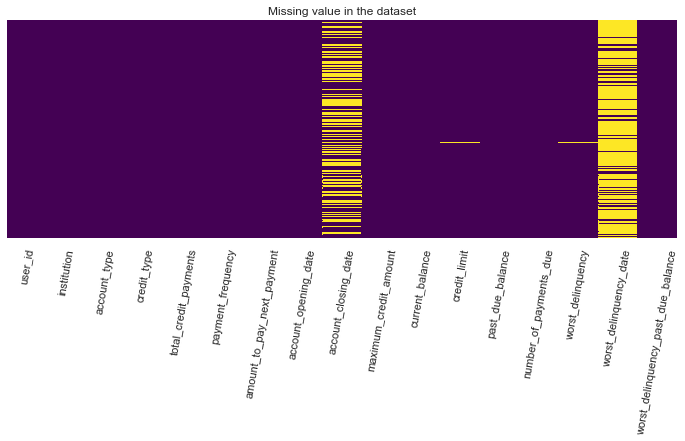

In [172]:
plt.figure(figsize=(12, 4))
sns.heatmap(data_credit_reports.isnull(),cbar=False,cmap='viridis',yticklabels=False)
plt.xticks(rotation=80) 
plt.title('Missing value in the dataset');

#### Categorical variables

In [182]:
data_credit_reports.describe(include=['object', 'bool'])

,institution,account_type,credit_type,payment_frequency
count,16309,16309,16309,16308
unique,54,8,26,10
top,BANCO,Pagos Fijos,Préstamo Personal,Mensual
freq,4285,8083,5717,11191


In [213]:
institution_count = pd.DataFrame(data_credit_reports['institution'].value_counts())
institution_count = institution_count.reset_index()

account_type_count = pd.DataFrame(data_credit_reports['account_type'].value_counts())
account_type_count = account_type_count.reset_index()

credit_type_count = pd.DataFrame(data_credit_reports['credit_type'].value_counts())
credit_type_count = credit_type_count.reset_index()

payment_frequency_count = pd.DataFrame(data_credit_reports['payment_frequency'].value_counts())
payment_frequency_count = payment_frequency_count.reset_index()

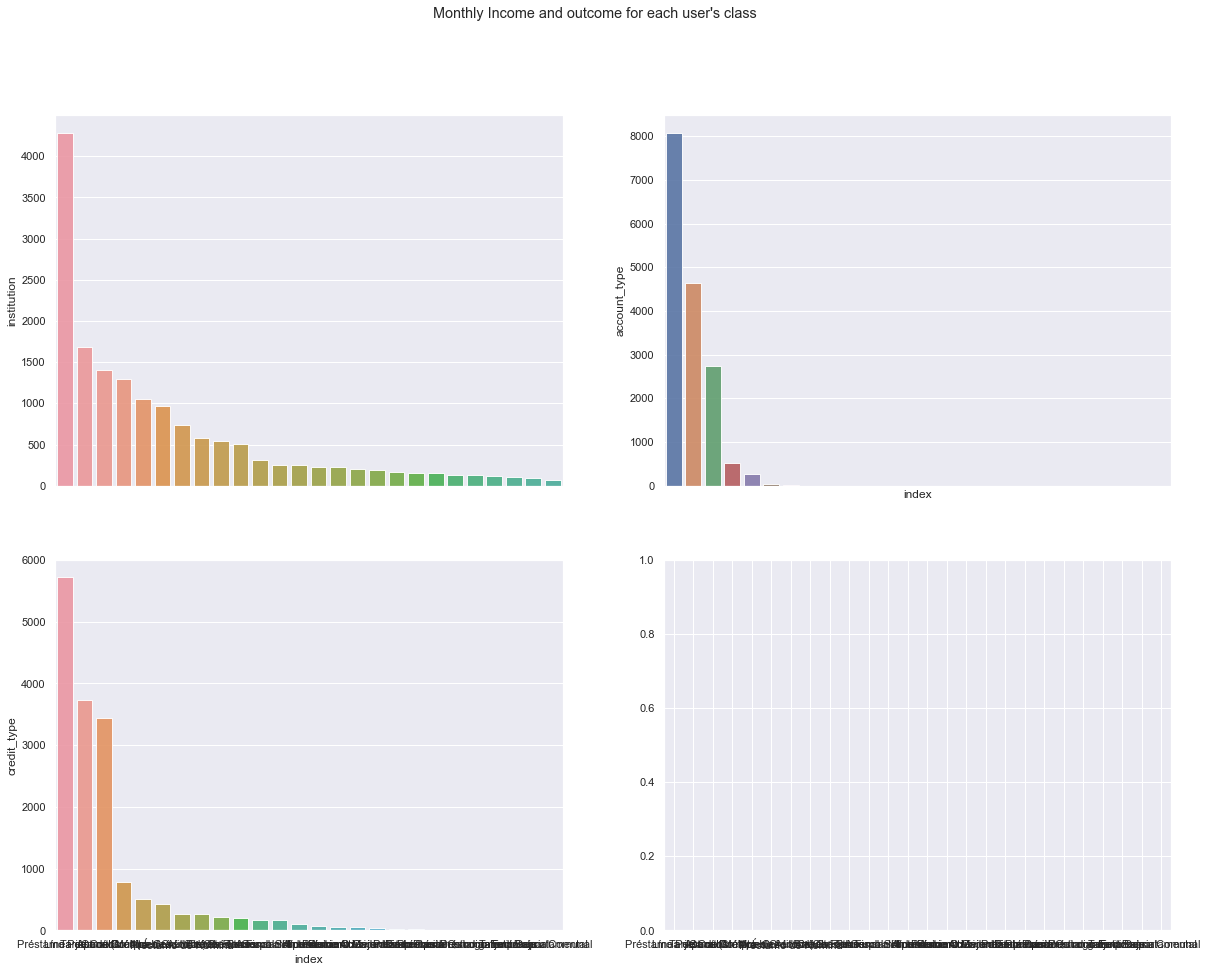

In [249]:

#plt.figure(figsize=(8, 6))

fig, axes = plt.subplots(2, 2, figsize=(20, 15), sharex=True)
fig.suptitle("Monthly Income and outcome for each user's class")

#axes1, axes2 = axes.ravel()
#axes1.set_ylim(0, 0.5e6) 
#axes2.set_ylim(0, 0.5e6) 
#plt.set(xlabel=None)


#sns.set(style="darkgrid")

p1 = sns.barplot(x=institution_count['index'], y='institution',  data=institution_count, alpha=0.9, ax=axes[0,0])
p1.set(xlabel=None)

p2 = sns.barplot(x=account_type_count['index'], y='account_type',  data=account_type_count, alpha=0.9, ax=axes[0,1])

p3 = sns.barplot(x=credit_type_count['index'], y='credit_type',  data=credit_type_count, alpha=0.9, ax=axes[1,0])

#p4 = sns.barplot(x=payment_frequency_count['index'], y='payment_frequency',  data=payment_frequency_count, alpha=0.9, ax=axes[1,1])


#plt.title("Frequency Distribution of classes' observations", fontsize=14)
#plt.ylabel('Number of Occurrences', fontsize=14)
#plt.xlabel('Class', fontsize=14)
#plt.show()




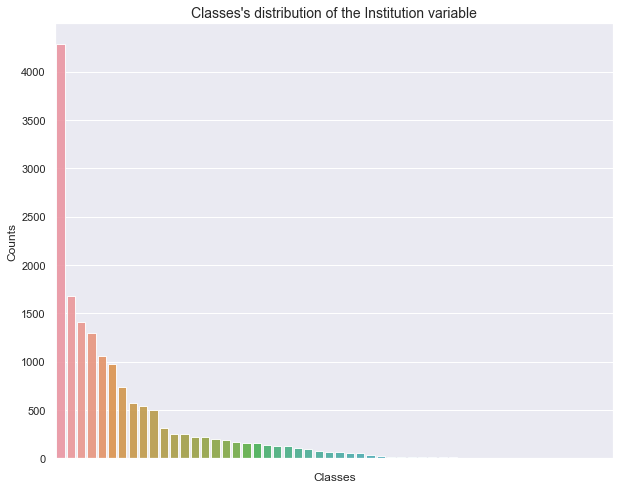

In [258]:
plt.figure(figsize=(10, 8))
p1= sns.barplot(x=institution_count['index'], y='institution',  data=institution_count, alpha=0.9)
p1.set(xticklabels=[])  
p1.set(xlabel='Classes', ylabel='Counts')
plt.title("Classes's distribution of the Institution variable", fontsize = 14)
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
p1= sns.barplot(x=institution_count['index'], y='institution',  data=institution_count, alpha=0.9)
p1.set(xticklabels=[])  
p1.set(xlabel='Classes', ylabel='Counts')
plt.title("Classes's distribution of the Institution variable", fontsize = 14)
plt.show()

<AxesSubplot:xlabel='institution', ylabel='count'>

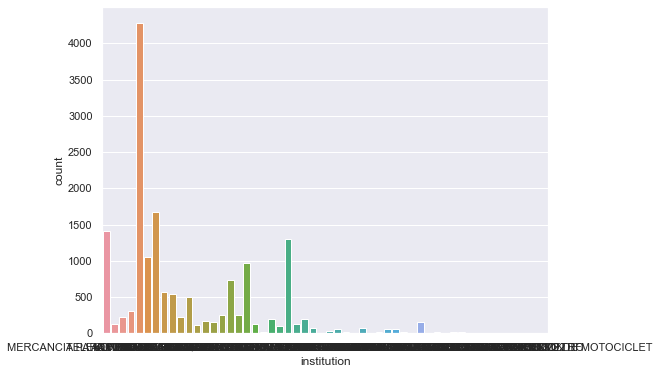

In [187]:
#sns.catplot(x="institution", kind="bar", data=data_credit_reports)
plt.figure(figsize=(8, 6))
sns.countplot(x="institution", data=data_credit_reports)

## Data Preparation

## Modeling

## Evaluation

## Deployment